In [3]:
import pandas as pd
import glob
import json
import re
import os

In [4]:
files = glob.glob("/log/worker1/shieldx-client*")

In [5]:
def load_multiline_json(path, run_id):
    records = []
    buffer = ""
    with open(path, "r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            buffer += line
            if line.endswith("}"):   # fin de objeto JSON
                try:
                    rec = json.loads(buffer)
                    rec["source_file"] = path
                    rec["run_id"] = run_id
                    records.append(rec)
                except Exception as e:
                    print("❌ Error parseando:", buffer[:100], e)
                buffer = ""  # reset
    return records

In [6]:
all_records = []

for f in files:
    if f.endswith(".error"):
        continue
    run_id = os.path.basename(f)  # usar el nombre del archivo como id de corrida
    all_records.extend(load_multiline_json(f, run_id))

df = pd.DataFrame(all_records)
print("Columnas:", df.columns)
print("Total registros:", len(df))
print("Corridas distintas:", df['run_id'].nunique())

Columnas: Index(['timestamp', 'level', 'logger_name', 'thread_name', 'event', 'path',
       'status', 'time', 'source_file', 'run_id'],
      dtype='object')
Total registros: 153305
Corridas distintas: 25


In [7]:
df["operation"] = df["event"].str.extract(r"CLIENT\.([A-Z_]+)")
def extract_entity(path: str) -> str:
    if path is None:
        return "unknown"
    if re.search(r"/event-types/.*/triggers", path):
        return "event_type_trigger"
    if re.search(r"/triggers/.*/rules", path):
        return "rule_trigger"
    if re.search(r"/triggers/.*/children", path):
        return "trigger_trigger"
    return path.strip("/").split("/")[0]

df["entity"] = df["path"].apply(extract_entity)

In [8]:
def map_to_crud(op: str) -> str:
    if op is None:
        return "OTHER"
    op = op.upper()
    # Primero DELETE/UNLINK/REMOVE
    if any(word in op for word in ["DELETE", "UNLINK", "REMOVE"]):
        return "DELETE"
    # Luego CREATE/LINK
    if any(word in op for word in ["CREATE", "LINK"]):
        return "CREATE"
    # Después READ
    if any(word in op for word in ["GET", "LIST", "READ"]):
        return "READ"
    # Después UPDATE
    if "UPDATE" in op or "REPLACE" in op:
        return "UPDATE"
    return "OTHER"

df["crud"] = df["operation"].apply(map_to_crud)


In [9]:
df

,timestamp,level,logger_name,thread_name,event,path,status,time,source_file,run_id,operation,entity,crud
0,"2025-08-25 12:17:59,021",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.057302,/log/worker1/shieldx-client.2025-08-25_12-17,shieldx-client.2025-08-25_12-17,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE
1,"2025-08-25 12:17:59,077",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.055411,/log/worker1/shieldx-client.2025-08-25_12-17,shieldx-client.2025-08-25_12-17,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE
2,"2025-08-25 12:17:59,130",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.052853,/log/worker1/shieldx-client.2025-08-25_12-17,shieldx-client.2025-08-25_12-17,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE
3,"2025-08-25 12:17:59,195",INFO,shieldx-client,MainThread,CLIENT.LINK_TRIGGER_TO_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.064187,/log/worker1/shieldx-client.2025-08-25_12-17,shieldx-client.2025-08-25_12-17,LINK_TRIGGER_TO_EVENT_TYPE,event_type_trigger,CREATE
4,"2025-08-25 12:17:59,250",INFO,shieldx-client,MainThread,CLIENT.LIST_TRIGGERS_FOR_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers,200,0.055018,/log/worker1/shieldx-client.2025-08-25_12-17,shieldx-client.2025-08-25_12-17,LIST_TRIGGERS_FOR_EVENT_TYPE,event_type_trigger,READ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153300,"2025-08-25 12:17:58,691",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.102001,/log/worker1/shieldx-client.2025-08-25_12-07,shieldx-client.2025-08-25_12-07,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE
153301,"2025-08-25 12:17:58,782",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.090130,/log/worker1/shieldx-client.2025-08-25_12-07,shieldx-client.2025-08-25_12-07,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE
153302,"2025-08-25 12:17:58,847",INFO,shieldx-client,MainThread,CLIENT.LINK_TRIGGER_TO_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers...,204,0.064743,/log/worker1/shieldx-client.2025-08-25_12-07,shieldx-client.2025-08-25_12-07,LINK_TRIGGER_TO_EVENT_TYPE,event_type_trigger,CREATE
153303,"2025-08-25 12:17:58,907",INFO,shieldx-client,MainThread,CLIENT.LIST_TRIGGERS_FOR_EVENT_TYPE.RESPONSE,/event-types/68aca67fa3a7f73b27b370cf/triggers,200,0.059882,/log/worker1/shieldx-client.2025-08-25_12-07,shieldx-client.2025-08-25_12-07,LIST_TRIGGERS_FOR_EVENT_TYPE,event_type_trigger,READ


In [10]:
crud_metrics = df.groupby(["entity", "crud"])["time"].agg(
    avg="mean", min="min", max="max", std="std", count="count"
).reset_index()

In [11]:
print("\n📊 Métricas totales:")
print(crud_metrics.sort_values(["entity", "crud"]))


📊 Métricas totales:
                entity    crud       avg       min       max       std  count
0          event-types  CREATE  0.063557  0.049483  0.235400  0.016471   5002
1          event-types  DELETE  0.065366  0.051574  0.286996  0.017200   5000
2          event-types    READ  0.063280  0.049681  0.191125  0.015830   5000
3   event_type_trigger  CREATE  0.065570  0.050634  0.223355  0.017313   5000
4   event_type_trigger  DELETE  0.063638  0.049523  0.336123  0.017147  15000
5   event_type_trigger    READ  0.063463  0.049648  0.294266  0.016797   5000
6   event_type_trigger  UPDATE  0.065548  0.051914  0.293859  0.017173   5000
7               events  CREATE  0.067653  0.051447  0.288796  0.019586   5000
8               events  DELETE  0.065058  0.049237  0.209921  0.018059   5000
9               events    READ  0.065569  0.050763  0.297767  0.018827   5000
10              events  UPDATE  0.067543  0.051471  0.255927  0.018696   5000
11        rule_trigger  CREATE  0.066326  0

In [12]:
crud_by_run = df.groupby(["run_id", "entity", "crud"])["time"].agg(
    avg="mean", min="min", max="max", std="std", count="count"
).reset_index()

print("\n📊 Métricas separadas por corrida:")
print(crud_by_run.head(20))


📊 Métricas separadas por corrida:
                             run_id              entity    crud       avg  \
0                    shieldx-client     trigger_trigger  CREATE  0.086999   
1                    shieldx-client     trigger_trigger  DELETE  0.083471   
2                    shieldx-client     trigger_trigger    READ  0.083208   
3                    shieldx-client            triggers    READ  0.083182   
4   shieldx-client.2025-08-25_00-48         event-types  CREATE  0.064183   
5   shieldx-client.2025-08-25_00-48         event-types  DELETE  0.065943   
6   shieldx-client.2025-08-25_00-48         event-types    READ  0.063745   
7   shieldx-client.2025-08-25_01-04         event-types  CREATE  0.062511   
8   shieldx-client.2025-08-25_01-04         event-types  DELETE  0.064448   
9   shieldx-client.2025-08-25_01-04         event-types    READ  0.062537   
10  shieldx-client.2025-08-25_12-07         event-types  CREATE  0.121187   
11  shieldx-client.2025-08-25_12-07  even

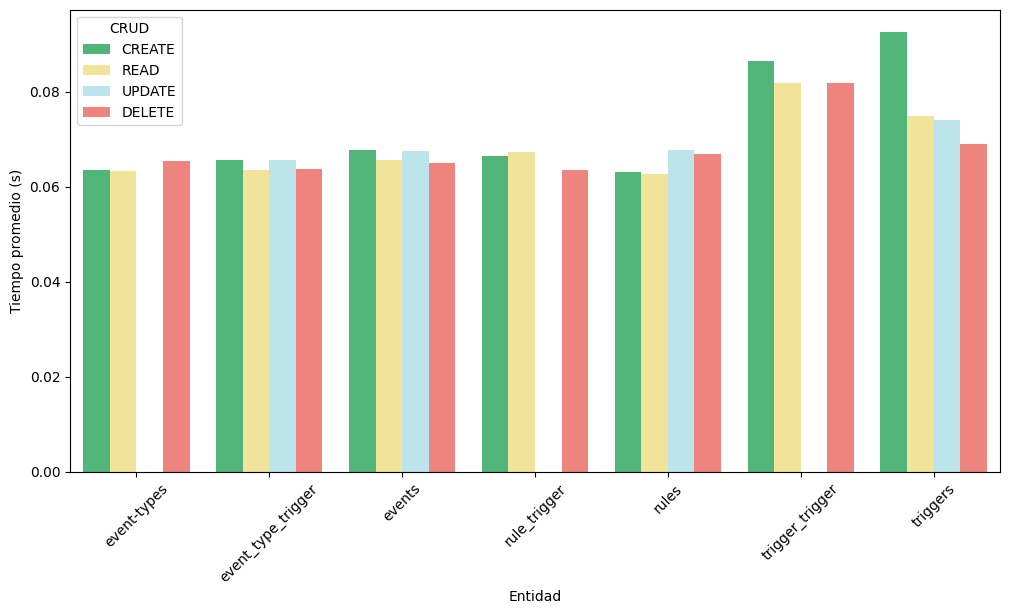

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reordenar niveles CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)

crud_avg = df.groupby(["entity", "crud"])["time"].mean().reset_index()
# Paleta de colores pastel
crud_palette = {
    "CREATE": "#40c576",   # verde pastel
    "READ":   "#ffee8c",   # amarillo pastel
    "UPDATE": "#b3ebf2",   # azul pastel
    "DELETE": "#ff746c"    # rojo pastel
}

# --- Barras promedio ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=crud_avg,
    x="entity",
    y="time",
    hue="crud",
    palette=crud_palette
)


plt.ylabel("Tiempo promedio (s)")
plt.xlabel("Entidad")
plt.xticks(rotation=45)
plt.legend(title="CRUD")
plt.show()



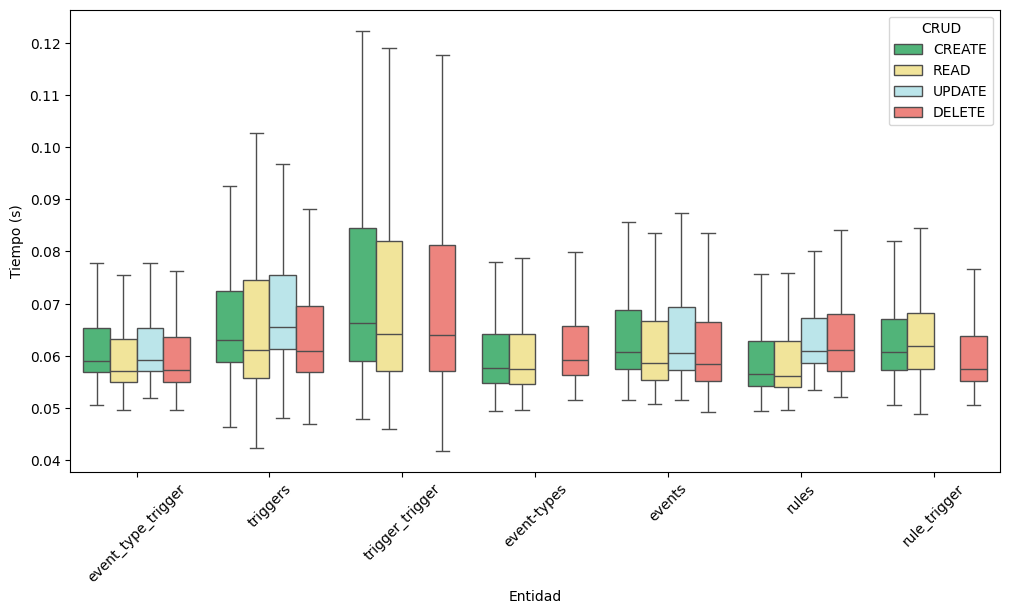

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mantener orden de CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)

# Paleta de colores pastel
crud_palette = {
    "CREATE": "#40c576",   # verde pastel
    "READ":   "#ffee8c",   # amarillo pastel
    "UPDATE": "#b3ebf2",   # azul pastel
    "DELETE": "#ff746c"    # rojo pastel
}

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df["crud"] != "OTHER"],  # usar df completo
    x="entity",
    y="time",
    hue="crud",
    palette=crud_palette,
    showfliers=False
)


plt.ylabel("Tiempo (s)")
plt.xlabel("Entidad")
plt.xticks(rotation=45)
plt.legend(title="CRUD")
plt.show()


/tmp/ipykernel_2407/2180608819.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


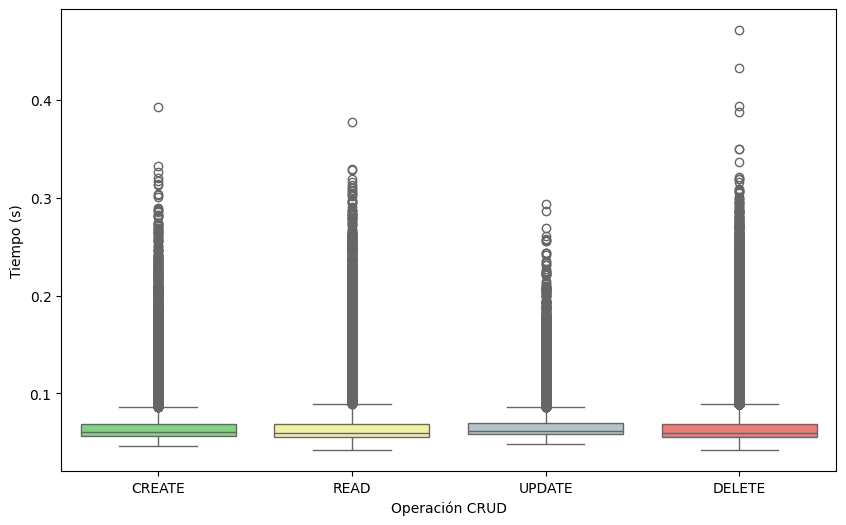

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo operaciones CRUD y tiempos menores a 2s
# Ordenar CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)


df_crud_only = df[
    (df["crud"].isin(["CREATE", "READ", "UPDATE", "DELETE"])) &
    (df["time"] <= 0.5)
]



# Paleta de colores pastel
crud_palette = {
    "CREATE": "#77dd77",   # verde pastel
    "READ":   "#fdfd96",   # amarillo pastel
    "UPDATE": "#aec6cf",   # azul pastel
    "DELETE": "#ff6961"    # rojo pastel
}

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_crud_only,
    x="crud",
    y="time",
    palette=crud_palette,
    showfliers=True   # si quieres ocultar todos los outliers pon False
)


plt.ylabel("Tiempo (s)")
plt.xlabel("Operación CRUD")
plt.show()
